In [1]:
# %matplotlib qt
# %matplotlib ipympl

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import easyocr

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.widgets import  Slider

In [2]:
VIDEO_PATH = "Videos/Start1.avi"

In [3]:
CAP = cv2.VideoCapture(VIDEO_PATH)
FPS = int(CAP.get(cv2.CAP_PROP_FPS))
LENTH = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / FPS)
CAP.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, START_FRAME = CAP.read()

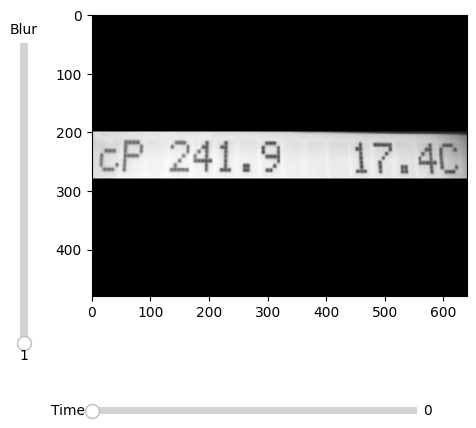

In [6]:
# Preprocess
def image_process(frame, blur=1):
    frame = cv2.blur(frame, (BLUR, BLUR))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.bitwise_not(frame)
    return frame


BLUR = 1

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
fig.subplots_adjust(left=0.25, right=1, bottom=0.25, top=1, hspace=0, wspace=0)

PLOT = ax.imshow(image_process(START_FRAME), cmap='binary')

ax_time_slider = fig.add_axes([0.25, 0.1, 0.65, 0.03])
TIME_slider = Slider(
    ax=ax_time_slider,
    label='Time',
    valmin=0,
    valmax=LENTH,
    valinit=0,
    valstep=1,
)

ax_blur_slider = fig.add_axes([0.1, 0.25, 0.03, 0.6])
BLUR_slider = Slider(
    ax=ax_blur_slider,
    orientation='vertical',
    label='Blur',
    valmin=BLUR,
    valmax=20,
    valinit=1,
    valstep=1,
)


def update(val):
    time = TIME_slider.val
    global BLUR
    BLUR = BLUR_slider.val

    CAP.set(cv2.CAP_PROP_POS_FRAMES, int(FPS * time))
    _, frame = CAP.read()
    frame = image_process(frame, blur=BLUR)

    PLOT.set_data(frame)
    PLOT.autoscale()

    fig.canvas.draw_idle()


TIME_slider.on_changed(update)
BLUR_slider.on_changed(update)
plt.show()

In [7]:
# input('Continue to selection?')
print(f'Blur value= {BLUR}')

Blur value= 1


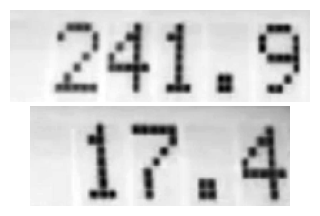

In [13]:
# Selection
def strict(image, x, y, w, h):
    return image[y:y + h, x:x + w]


SLICE_CORDS = []
values_to_recognize = int(input('Valaues to recognize: '))

for i in range(values_to_recognize):
    roi_frame = image_process(START_FRAME, blur=BLUR)
    roi_frame = cv2.bitwise_not(roi_frame)
    current_slice = cv2.selectROI(
        f'Select {len(SLICE_CORDS)+1}',
        roi_frame,
        fromCenter=False,
        showCrosshair=True,
    )
    SLICE_CORDS.append(current_slice)
cv2.destroyAllWindows()

fig, axes = plt.subplots(nrows=values_to_recognize)
if not isinstance(axes, np.ndarray): axes = [axes]
fig.set_size_inches(3, 1 * values_to_recognize)
fig.subplots_adjust(left=0, right=1, bottom=0.0, top=1, hspace=0, wspace=0)
start_slices = [
    strict(image_process(START_FRAME, blur=BLUR), *params)
    for params in SLICE_CORDS
]
for i in range(values_to_recognize):
    axes[i].set_axis_off()
    axes[i].imshow(start_slices[i], cmap='binary')

In [14]:
# Recognize
def correct(values):
    return values


reader = easyocr.Reader(['en'])
# TODO: add input
frames_per_sec = 1
diap = tqdm(iterable=range(0, FPS * LENTH, int(FPS / frames_per_sec)))

data = []
for i_frame in diap:
    CAP.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    _, frame = CAP.read()
    i_text = []
    for select_window in SLICE_CORDS:
        selection = strict(frame, *select_window)
        selection = image_process(selection, blur=BLUR)
        values = [
            (value, round(confidence,3)) for _, value, confidence
            in reader.readtext(selection)
            ] #yapf:disable

        i_text.append(values)

    data.append(i_text)


100%|██████████| 54/54 [00:07<00:00,  7.35it/s]
